# DenseNet201

In [1]:
# Al tener los datos subidos en el One Drive personal debemos de llamarlos y
# guardarlos en el entorno de Google Colab

from google.colab import drive # Llamamos a la librería necesaria

drive.mount('/gdrive') # Monta el drive en Google Colab y establece la ruta de acceso.
%cp -r /gdrive/MyDrive/UEM/data/TFM/* /content/ # Cogemos todos los datos de la ruta

Mounted at /gdrive


In [2]:
import pickle

# Carga de datos de entrenamiento
with open('./IDC_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)

# Carga de datos de test
with open('./IDC_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)

# Comprobamos la cantidad de datos que tenemos
print(X_train.shape)
print(y_train.shape)

(222019, 50, 50, 3)
(222019,)


In [4]:
from sklearn.model_selection import train_test_split

# Obtiene el 30% de los datos de entrenamiento
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Obtiene el 30% de los datos de prueba
X_test_subset, _, y_test_subset, _ = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

# Imprime las formas de los conjuntos reducidos
print("Forma de X_train_subset:", X_train_subset.shape)
print("Forma de y_train_subset:", y_train_subset.shape)
print("Forma de X_test_subset:", X_test_subset.shape)
print("Forma de y_test_subset:", y_test_subset.shape)

Forma de X_train_subset: (155413, 50, 50, 3)
Forma de y_train_subset: (155413,)
Forma de X_test_subset: (38853, 50, 50, 3)
Forma de y_test_subset: (38853,)


### Show Images with labels

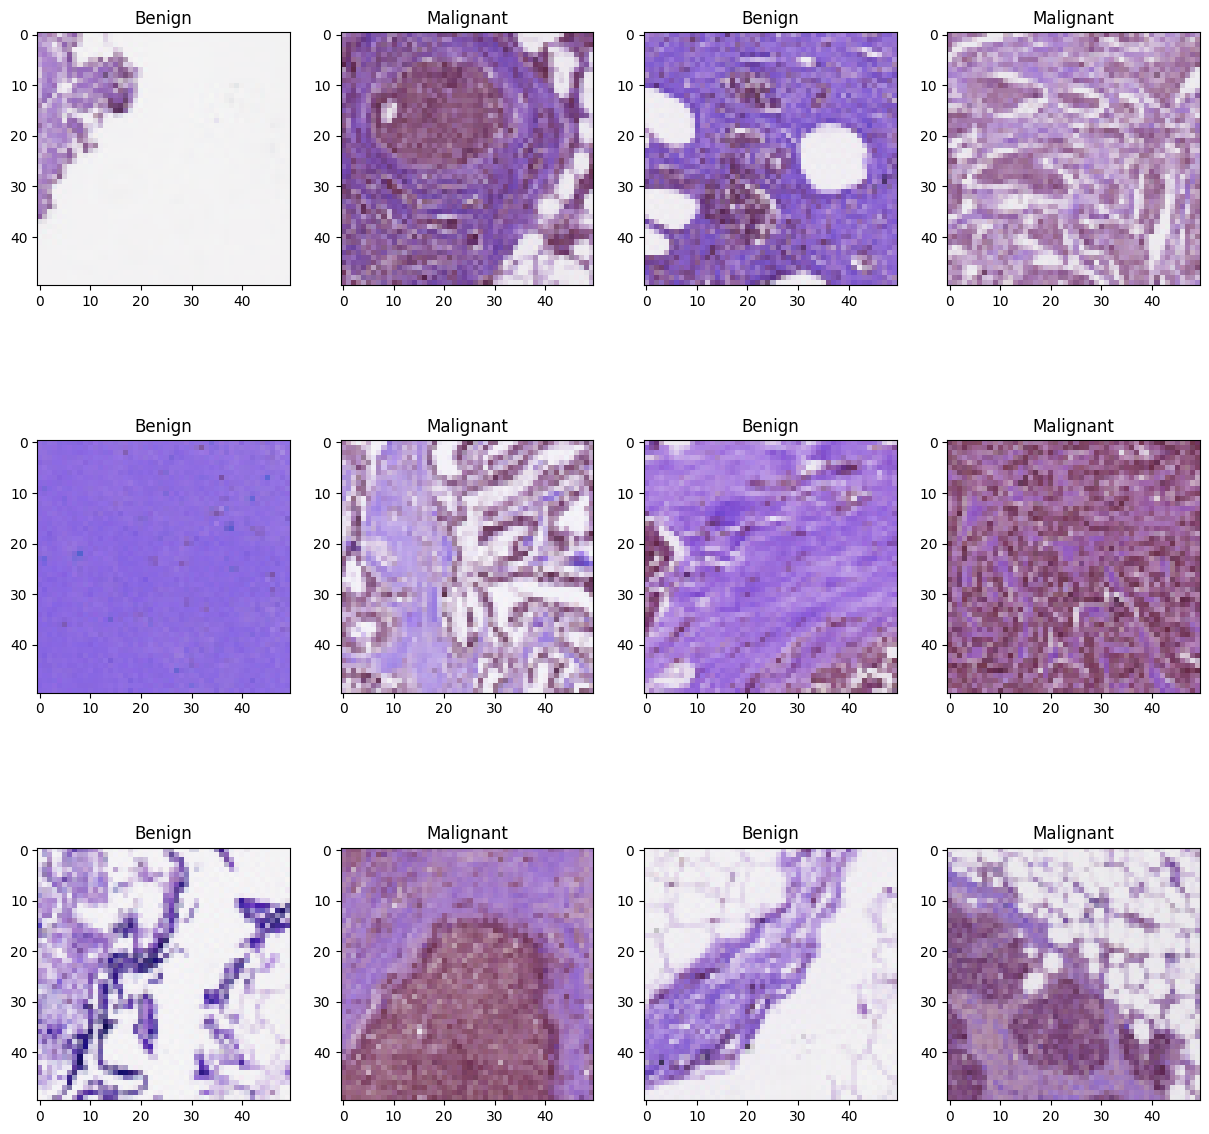

In [5]:
import matplotlib.pyplot as plt

w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

# Filtrar las imágenes y etiquetas según su categoría
benign_images = X_train[y_train == 0]
malignant_images = X_train[y_train == 1]

# Calcular el número máximo de imágenes a mostrar
max_images = min(len(benign_images), len(malignant_images))

for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    if i % 2 == 1:
        # Mostrar una imagen benigna
        index = (i - 1) // 2
        ax.title.set_text('Benign')
        plt.imshow(benign_images[index], interpolation='nearest')
    else:
        # Mostrar una imagen maligna
        index = (i - 1) // 2
        ax.title.set_text('Malignant')
        plt.imshow(malignant_images[index], interpolation='nearest')

    if i >= 2 * max_images:
        # Si ya hemos mostrado el número máximo de imágenes, salir del bucle
        break

plt.show()

## DenseNet201

In [6]:
import json
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools
from keras.utils import plot_model

In [7]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [8]:
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense
from keras.models import Sequential
from keras.optimizers import Adam

def build_model(backbone, num_neurons, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Additional layers
    model.add(Dense(num_neurons, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))  # Cambio a 1 salida con activación sigmoidal

    model.compile(
        loss='binary_crossentropy',  # Cambio a binary_crossentropy
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    return model

In [ ]:
# Define the input shape
input_shape = (50, 50, 3)  # Adjust the number of channels if necessary

# Create DenseNet201 model
resnet = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# Define training parameters
num_neurons_list = [10, 20, 30]
lr = 1e-4
epochs = 10
BATCH_SIZE = 32

for num_neurons in num_neurons_list:
    K.clear_session()
    gc.collect()

    # Build the model with different numbers of neurons
    model = build_model(resnet, num_neurons, lr)

    # Learning Rate Reducer
    learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                      verbose=1, factor=0.2, min_lr=1e-7)

    # Checkpoint
    filepath = f"weights.best_{num_neurons}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')

    # Train the model
    history = model.fit(
        X_train_subset, y_train_subset,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(X_test_subset, y_test_subset),
        callbacks=[learn_control, checkpoint]
    )

    # Save the history as a pickle file
    history_filepath = f"DenseNet201_history_{num_neurons}.pkl"
    with open(history_filepath, 'wb') as file:
        pickle.dump(history.history, file)

    # Save the trained model
    model_filepath = f"DenseNet201_Model_{num_neurons}.h5"
    model.save(model_filepath)

74836368/74836368 [==============================] - 3s 0us/step
Epoch 1/10
4857/4857 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8637
Epoch 1: val_accuracy improved from -inf to 0.86310, saving model to weights.best_10.hdf5
4857/4857 [==============================] - 391s 74ms/step - loss: 0.3211 - accuracy: 0.8637 - val_loss: 0.3157 - val_accuracy: 0.8631 - lr: 1.0000e-04
Epoch 2/10
4857/4857 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.8850
Epoch 2: val_accuracy improved from 0.86310 to 0.88402, saving model to weights.best_10.hdf5
4857/4857 [==============================] - 347s 71ms/step - loss: 0.2726 - accuracy: 0.8850 - val_loss: 0.2803 - val_accuracy: 0.8840 - lr: 1.0000e-04
Epoch 3/10
4857/4857 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.8957
Epoch 3: val_accuracy improved from 0.88402 to 0.89527, saving model to weights.best_10.hdf5
4857/4857 [==============================] - 345s 71ms/step

In [10]:
import shutil
import os

destination_folder = '/gdrive/MyDrive/UEM/data/TFM/DenseNet201'

os.makedirs(destination_folder, exist_ok=True)

# Ruta del archivo en Colab
source_folder = '/content/'

# Mover los archivos a la nueva carpeta en Google Drive
for file_name in os.listdir(source_folder):
    if file_name != 'drive' and not file_name.endswith('.dat'):
        shutil.move(os.path.join(source_folder, file_name), os.path.join(destination_folder, file_name))

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
history_df[['loss', 'val_loss']].plot()

In [ ]:
Y_val_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(Y_val_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
from sklearn.metrics import classification_report
classification_report(np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()